In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
from sklearn.metrics import roc_auc_score
from skimage.metrics import structural_similarity as compare_ssim
warnings.filterwarnings('ignore')

def compute_luminance(img1, img2):
    """compute luminance of two images"""
    return np.mean(img1), np.mean(img2)

def compute_contrast(img1, img2):
    """compute contrast of two images"""
    return np.std(img1), np.std(img2)

def calculate_metrics(gt, edge_detected):
    """compute f1-score and AUC score"""
    TP = np.sum((gt == 255) & (edge_detected == 255))
    FP = np.sum((gt == 0) & (edge_detected == 255))
    FN = np.sum((gt == 255) & (edge_detected == 0))
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # harmonic mean of recall and precision 
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
    # auc score 
    gt_binary = ((gt == 255).flatten()).astype(int)
    edge_detected_binary = ((edge_detected == 255).flatten()).astype(int)
    try : 
        auc_score = roc_auc_score(gt_binary, edge_detected_binary)
    except : 
        auc_score = 0.5
    return f1_score, auc_score

def transform_img(img, seed) : 
    """random transformation with brightness, contrast"""
    v = np.arange(0.2, 2.1, 0.1)
    np.random.seed(seed)
    factor1 = np.random.choice(v)
    np.random.seed(seed+1)
    factor2 = np.random.choice(v)
    
    img = np.array(255 * (img / 255) ** factor1, dtype='uint8')
    return  cv2.multiply(img, factor2)

def edge_detection(image, filter_type, kernel_size, auto_method):
    if len(image.shape) == 3 :
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else :
        gray = image.copy()
        
    if filter_type == 'gauss' : 
        blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    elif filter_type == 'guided' :
        blur = cv2.ximgproc.guidedFilter(guide=gray.copy(), src=gray, radius=kernel_size, eps=eps)
    else : 
        blur = cv2.medianBlur(gray, kernel_size)
        
    if auto_method == 'median' :
        edge = auto_canny(blur)
    else : 
        edge = auto_canny_otsu(blur)
        
    return edge

def simplify_edges(edge) : 
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    count_threshold = np.percentile([len(c) for c in contours], 50)
    length_threshold = np.percentile([cv2.arcLength(c, True) for c in contours], 50)
    contour_list = [c for c in contours if len(c) > count_threshold and cv2.arcLength(c, True) > length_threshold]         
    binary_contour_image = np.zeros(edge.shape, dtype=np.uint8)
    cv2.drawContours(binary_contour_image, contour_list, -1, (255, 255, 255), 1)
    return binary_contour_image

In [2]:
"""Edge Detecting Method (Canny thresholding)"""

def auto_canny(img, sigma=0.33) : 
    if len(img.shape) == 3 :
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    v = np.median(img)
    lower = int(max(0, 1.0 - sigma)*v)
    upper = int(min(255, (1.0 + sigma)*v ))
    return cv2.Canny(img, lower, upper)

def auto_canny_otsu(image):
    if len(image.shape) == 3 :
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high_thresh, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
    return cv2.Canny(image, low_thresh, high_thresh)

def canny(img) : 
    if len(img.shape) == 3 :
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(img, 100, 200)

In [3]:
"""cost function / edge evaluating methods"""

def compute_performance_metric(edge_image, ground_truth, f, ksize, m):
    # F1, AUC, ESSIM, continuity (엣지 연결성)
    f1, auc = calculate_metrics(edge_image,ground_truth)
    essim = compute_essim(edge_image, ground_truth, f, ksize, m)
#     continuity = measure_continuity(edge_image)
    edge_seg, edgels = find_edges_and_segments(edge_image)
    epsilon = 1e-10
    continuity = len(edgels) / (len(edge_seg) + epsilon)
    return f1 * 0.33 + essim * 0.33 + continuity * 0.33


def find_edges_and_segments(binary_image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    edge_segments = contours  # All contours are considered as edge segments
    
    # Filter or process contours to find edge lines
    edge_lines = []
    for contour in contours:
        # You can filter based on the length of the contour or use approximation
        if len(contour) > 15 :  # Define some_length_threshold as per your requirement
            # Approximate the contour to simplify it
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            edge_lines.append(approx)
    
    return edge_segments, edge_lines


def compute_essim(img1, img2, f, ksize, m):
    luminance1, luminance2 = compute_luminance(img1, img2)
    contrast1, contrast2 = compute_contrast(img1, img2)
    edges1, edges2 = edge_detection(img1, f, ksize, m), edge_detection(img2, f, ksize, m)

    l = (2 * luminance1 * luminance2 + 0.01) / (luminance1**2 + luminance2**2 + 0.01)
    c = (2 * contrast1 * contrast2 + 0.03) / (contrast1**2 + contrast2**2 + 0.03)
    e = compare_ssim(edges1, edges2)

    return l * 0.33 + c * 0.33 + e * 0.33


# def measure_continuity(edges, max_gap=5):
#     # 연속성을 확인하기 위해 엣지 픽셀의 좌표를 찾음
#     y_coords, x_coords = np.where(edges == 255)
#     edge_points = list(zip(x_coords, y_coords))

#     # 각 엣지 픽셀에 대해 이전 픽셀과의 거리를 계산
#     distances = [np.sqrt((x - edge_points[i - 1][0])**2 + (y - edge_points[i - 1][1])**2) 
#                  for i, (x, y) in enumerate(edge_points) if i > 0]

#     # 거리가 max_gap 이하인 경우를 연속적인 것으로 간주
#     continuous_edges = sum(d <= max_gap for d in distances)
#     total_edges = len(distances)

#     # 연속성 비율 계산
#     continuity_ratio = continuous_edges / total_edges if total_edges > 0 else 0
#     return continuity_ratio


In [4]:
def searching_best_params(first_frame) :
    filter_type = ['gauss', 'median', ] # 'guided']
    auto_method = ['median','otsu']
    kernel_sizes=[5,7,9]

    # 그리드 서치 실행
    best_score = 0
    best_params = {}

    gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    for f, ksize, m in product(filter_type, kernel_sizes, auto_method) :
        # 각 조합마다 10번 수행, 평균 도출
        rand_scores = 0  
        for i in range(10) :
            GT = edge_detection(gray, f, ksize, m)

            rand_img  =  transform_img(gray, seed=i)
            rand_edge = edge_detection(rand_img, f, ksize, m)
            rand_scores += compute_performance_metric(rand_edge, GT, f, ksize, m)

        rand_scores = rand_scores / 10 

        if rand_scores > best_score:
            best_score = rand_scores
            best_params = {"kernel_size" : ksize, "filter_type" : f,
                          'auto_method' : m}
    print('=' * 25)
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_params

In [30]:
def run_best_edge_detector(image, **params) :
#     for key, val in params.items() :
#         print(key, val)
    if params :
        ksize = params['kernel_size']
        ftype = params['filter_type']
        auto_method = params['auto_method']
        if ftype == 'gauss' :
            blur = cv2.GaussianBlur(image, (ksize, ksize), 0)
        elif ftype == 'median' : 
            blur = cv2.medianBlur(image, ksize)
        else :
            blur = image.copy()
        
        if auto_method == 'median' : 
            edge = auto_canny(blur)
        else :
            edge = auto_canny_otsu(blur)
    else :
        edge = canny(image)
    return edge

In [132]:
def find_new_points(frame, hough_threshold, angle_threshold, dist_threshold, **params) : 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = run_best_edge_detector(gray, **params)
    simplified = simplify_edges(edges)
    lines = cv2.HoughLinesP(simplified, 1, np.pi/180, hough_threshold, minLineLength=min_line_length,
                           maxLineGap=max_line_gap)
    new_points = []
    filtered_lines = None
    if lines is not None :
        filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
    if filtered_lines is not None :
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            new_points.append([x1, y1])
            new_points.append([x2, y2])
            
        lines = filtered_lines.copy()  
    
    return new_points, lines, simplified

# def find_new_points(frame, hough_threshold, angle_threshold, dist_threshold, **params) : 
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     edges = run_best_edge_detector(gray, **params)
#     simplified = simplify_edges(edges)
#     lines = cv2.HoughLinesP(simplified, 1, np.pi/180, hough_threshold, minLineLength=min_line_length,
#                            maxLineGap=max_line_gap)
#     new_points = []
#     filtered_lines = None
#     if lines is not None :
#         for line in lines :
#             new_points.append([x1, y1])
#             new_points.append([x2, y2])
    
#     return new_points, lines, simplified



def is_point_on_valid_line(point, lines, threshold=25): # threshold=10
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist = cv2.pointPolygonTest(np.array([[x1, y1], [x2, y2]]), (point[0], point[1]), True)
        if abs(dist) < threshold:
            return True
    return False

def remove_close_points(points, threshold):
    valid_points = []
    for i, point in enumerate(points):
        too_close = False
        for j, other_point in enumerate(points):
            if i != j and distance_between_points(point, other_point) < threshold:
                too_close = True
                break
        if not too_close:
            valid_points.append(point)
    return np.array(valid_points)

def get_angle(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def get_midpoint(line):
    x1, y1, x2, y2 = line[0]
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def get_line_length(line):
    x1, y1, x2, y2 = line[0]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def distance_between_points(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def filter_lines(lines, angle_threshold, dist_threshold):
    filtered_lines = []
    used = [False] * len(lines)

    for i in range(len(lines)):
        if not used[i]:
            max_length = get_line_length(lines[i])
            selected_line = lines[i]
            x1, y1, x2, y2 = lines[i][0]
            angle_i = get_angle(x1, y1, x2, y2)
            midpoint_i = get_midpoint(lines[i])
            used[i] = True

            for j in range(i + 1, len(lines)):
                if not used[j]:
                    x1, y1, x2, y2 = lines[j][0]
                    angle_j = get_angle(x1, y1, x2, y2)
                    if abs(angle_i - angle_j) <= angle_threshold:
                        midpoint_j = get_midpoint(lines[j])
                        if distance_between_points(midpoint_i, midpoint_j) < dist_threshold:
                            length = get_line_length(lines[j])
                            if length > max_length:
                                selected_line = lines[j]
                                max_length = length
                            used[j] = True
            filtered_lines.append(selected_line)

    return filtered_lines


In [96]:
cap = cv2.VideoCapture("./test1.mp4")
_, first_frame = cap.read()
best_params = searching_best_params(first_frame)

Best Parameters: {'kernel_size': 9, 'filter_type': 'median', 'auto_method': 'otsu'}
Best Score: 0.8234715280079413


In [129]:
angle_threshold = 15 # 중복제거 선 각도 임계
dist_threshold = 15   # 중복제거 선 거리 임계
threshold_distance = 25 # 중복제거 점간 거리 임계
hough_threshold = 100
min_line_length = 120
max_line_gap = 100

lk_params = dict(winSize=(21, 21), maxLevel=2, 
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
                           10, 0.03))

In [133]:
cap = cv2.VideoCapture("./test1.mp4")

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

p0, _, edges = find_new_points(old_frame, hough_threshold, angle_threshold, dist_threshold, **best_params)

print(p0)

# [[403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5], [403, 140], [410, 5]]

p0 = np.array(p0,dtype=np.float32)
p0 = remove_close_points(p0, threshold_distance)
frame_idx = 0
height, width = old_gray.shape

inside_frame = (p0[:, 0] > 0) & (p0[:, 0] < old_frame.shape[1]) & \
               (p0[:, 1] > 0) & (p0[:, 1] < old_frame.shape[0])
p0 = p0[inside_frame]
p0 = np.array(p0, dtype=np.float32).reshape(-1, 1, 2)
print("초기 시작점 개수 :",len(p0))

[[23, 301], [486, 1], [532, 219], [551, 0], [507, 214], [522, 7], [214, 178], [214, 9], [270, 30], [637, 338], [4, 312], [301, 120], [270, 39], [610, 286], [473, 186], [486, 0], [403, 140], [410, 5]]
초기 시작점 개수 : 11


In [99]:
import time, traceback 
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#     edges = run_best_edge_detector(frame)
#     simplified = simplify_edges(edges)
    
#     edges = run_best_edge_detector(frame)
    try : 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None :
            good_new = p1[st == 1].reshape(-1, 2)
        good_old = p0[st == 1].reshape(-1, 2)
        new_p, lines, edges = find_new_points(frame, hough_threshold, angle_threshold, dist_threshold, **best_params)
        new_p =  np.array(new_p, dtype=np.float32).reshape(-1, 1, 2)
        if len(new_p) > 0:
            new_p = new_p.reshape(-1, 2) 
            good_new = np.vstack((good_new, new_p))  

        inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                       (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
        good_new = good_new[inside_frame]

        valid_points = [] 

        for point in good_new:
            if is_point_on_valid_line(point, lines):
                valid_points.append(point)
        
        valid_points = np.array(valid_points)
        valid_points = remove_close_points(valid_points, threshold_distance)

        for point in valid_points :
            a, b = point.ravel()
            a, b = int(a), int(b)
            cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    except Exception as e :
        print(traceback.format_exc())
    
    finally : 
        
        if lines is not None :
            for line in lines :
                x1, y1, x2, y2 = line[0]
                angle = get_angle(x1, y1, x2, y2)               
                """only vertical lines"""
                if abs(angle) > 80 and abs(angle) < 100 :  # vertical line 
                    cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
                else :
                    cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 1)   
        
        cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))
#         cv2.imshow('TEST', cv2.hconcat([edges, simplified]))
        
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
#         print(f"computing time : {time.time() - start : .2f}")
        old_gray = frame_gray.copy()
        p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)
        frame_idx += 1
    
cv2.destroyAllWindows()
cap.release()

In [104]:
cap = cv2.VideoCapture("./test1.mp4")

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

p0, _, edges = find_new_points(old_frame, hough_threshold, angle_threshold, dist_threshold, **best_params)

p0 = np.array(p0,dtype=np.float32)
# p0 = remove_close_points(p0, threshold_distance)
frame_idx = 0
height, width = old_gray.shape

inside_frame = (p0[:, 0] > 0) & (p0[:, 0] < old_frame.shape[1]) & \
               (p0[:, 1] > 0) & (p0[:, 1] < old_frame.shape[0])
p0 = p0[inside_frame]
p0 = np.array(p0, dtype=np.float32).reshape(-1, 1, 2)
print("초기 시작점 개수 :",len(p0))

초기 시작점 개수 : 16


In [120]:
gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
edges = run_best_edge_detector(gray, **best_params)
simplified = simplify_edges(edges)
lines = cv2.HoughLinesP(simplified, 1, np.pi/180, hough_threshold, minLineLength=min_line_length,
                       maxLineGap=max_line_gap)
new_points = []
filtered_lines = None
if lines is not None :
    filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
# lines = filtered_lines.copy() 
if filtered_lines is not None :
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]
        new_points.append([x1, y1])
        new_points.append([x2, y2])

    lines = filtered_lines.copy()  
    
    
window = old_gray.copy()

    
if lines is not None :
    for line in lines :
        x1, y1, x2, y2 = line[0]
        angle = get_angle(x1, y1, x2, y2)               
        """only vertical lines"""
        if abs(angle) > 80 and abs(angle) < 100 :  # vertical line 
            cv2.line(window, (x1, y1), (x2, y2), (255, 0, 0), 3)
            cv2.circle(window, (x1, y1), radius=3, color=(255, 0, 0), thickness=3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (0,255, 0), 1)  
            cv2.circle(window, (x2, y2), radius=3, color=(255, 0, 0), thickness=3)

## 수정 본 

In [153]:
angle_threshold = 15 # 중복제거 선 각도 임계
dist_threshold = 15   # 중복제거 선 거리 임계
threshold_distance = 25 # 중복제거 점간 거리 임계
hough_threshold = 100
min_line_length = 120
max_line_gap = 100

lk_params = dict(winSize=(21, 21), maxLevel=2, 
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
                           10, 0.03))

In [151]:
cap = cv2.VideoCapture("./test1.mp4")

ret, old_frame = cap.read()

old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
edges = run_best_edge_detector(old_gray, **best_params)
simplified = simplify_edges(edges)
lines = cv2.HoughLinesP(simplified, 1, np.pi/180, hough_threshold, minLineLength=min_line_length,
                       maxLineGap=max_line_gap)

# print(lines)

points = np.reshape(lines, (-1, 2))
p0 = points.reshape(-1, 1, 2)

print(len(p0))

18


In [152]:
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    try : 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None :
            good_new = p1[st == 1].reshape(-1, 2)
        good_old = p0[st == 1].reshape(-1, 2)
        
        edges = run_best_edge_detector(frame_gray, **best_params)
        simplified = simplify_edges(edges)
        lines = cv2.HoughLinesP(simplified, 1, np.pi/180, hough_threshold, minLineLength=min_line_length,
                               maxLineGap=max_line_gap)
        points = np.reshape(lines, (-1, 2))
        new_p =  np.array(points, dtype=np.float32).reshape(-1, 1, 2)
        if len(new_p) > 0:
            new_p = new_p.reshape(-1, 2) 
            good_new = np.vstack((good_new, new_p))  

        inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                       (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
        good_new = good_new[inside_frame]

        valid_points = [] 

        for point in good_new:
            if is_point_on_valid_line(point, lines):
                valid_points.append(point)
        
        valid_points = np.array(valid_points)
        valid_points = remove_close_points(valid_points, threshold_distance)

        for point in valid_points :
            a, b = point.ravel()
            a, b = int(a), int(b)
            cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    except Exception as e :
        print(traceback.format_exc())
    
    finally : 
        
        if lines is not None :
            for line in lines :
                x1, y1, x2, y2 = line[0]
                angle = get_angle(x1, y1, x2, y2)               
                """only vertical lines"""
                if abs(angle) > 80 and abs(angle) < 100 :  # vertical line 
                    cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
                else :
                    cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 1)   
        
        cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))
#         cv2.imshow('TEST', cv2.hconcat([edges, simplified]))
        
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
#         print(f"computing time : {time.time() - start : .2f}")
        old_gray = frame_gray.copy()
        p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)
        frame_idx += 1
    
cv2.destroyAllWindows()
cap.release()

Traceback (most recent call last):
  File "C:\Users\yeseul\AppData\Local\Temp\ipykernel_6156\1977827479.py", line 9, in <cell line: 2>
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
cv2.error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\video\src\lkpyramid.cpp:1260: error: (-215:Assertion failed) (npoints = prevPtsMat.checkVector(2, CV_32F, true)) >= 0 in function 'cv::`anonymous-namespace'::SparsePyrLKOpticalFlowImpl::calc'




---

In [ ]:
# lines = cv2.HoughLinesP(simplified, 1, np.pi/180, hough_threshold, minLineLength=min_line_length,
#                        maxLineGap=max_line_gap)

# 여기서 나온 lines 요소들 중에 frame 밖에 있는 point 요소는 frame 내에 보이는 마지막 직선 픽셀의 point 위치로 바꿔지도록 코딩 가능? 예를 들면 (

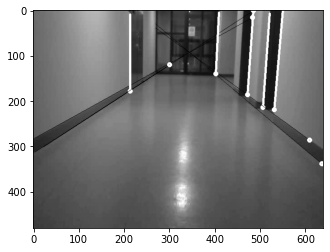

In [140]:
window = gray.copy()

if lines is not None :
    for line in lines :
        x1, y1, x2, y2 = line[0]
        angle = get_angle(x1, y1, x2, y2)               
        """only vertical lines"""
        if abs(angle) > 80 and abs(angle) < 100 :  # vertical line 
            cv2.line(window, (x1, y1), (x2, y2), (255, 0, 0), 3)
            cv2.circle(window, (x1, y1), radius=3, color=(255, 0, 0), thickness=3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (0,255, 0), 1)  
            cv2.circle(window, (x2, y2), radius=3, color=(255, 0, 0), thickness=3)
            
plt.imshow(window, cmap='gray')

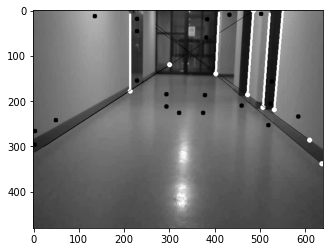

In [119]:
# window = old_gray.copy()
for point in valid_points :
    a, b = point.ravel()
    a, b = int(a), int(b)
    cv2.circle(window, (a, b), 5, (0, 255, 0), -1)
    
plt.imshow(window, cmap='gray')

In [101]:
import time, traceback 
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#     edges = run_best_edge_detector(frame)
#     simplified = simplify_edges(edges)
    
#     edges = run_best_edge_detector(frame)
    try : 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None :
            good_new = p1[st == 1].reshape(-1, 2)
        good_old = p0[st == 1].reshape(-1, 2)
        new_p, lines, edges = find_new_points(frame, hough_threshold, angle_threshold, dist_threshold, **best_params)
        new_p =  np.array(new_p, dtype=np.float32).reshape(-1, 1, 2)
        if len(new_p) > 0:
            new_p = new_p.reshape(-1, 2) 
            good_new = np.vstack((good_new, new_p))  

        inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                       (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
        good_new = good_new[inside_frame]

        valid_points = [] 

        for point in good_new:
#             if is_point_on_valid_line(point, lines):
            valid_points.append(point)
        
        valid_points = np.array(valid_points)
        valid_points = remove_close_points(valid_points, threshold_distance)

        for point in valid_points :
            a, b = point.ravel()
            a, b = int(a), int(b)
            cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    except Exception as e :
        print(traceback.format_exc())
    
    finally : 
        
        if lines is not None :
            for line in lines :
                x1, y1, x2, y2 = line[0]
                angle = get_angle(x1, y1, x2, y2)               
                """only vertical lines"""
                if abs(angle) > 80 and abs(angle) < 100 :  # vertical line 
                    cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
                else :
                    cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 1)   
        
        cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))
#         cv2.imshow('TEST', cv2.hconcat([edges, simplified]))
        
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
#         print(f"computing time : {time.time() - start : .2f}")
        old_gray = frame_gray.copy()
        p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)
        frame_idx += 1
    
cv2.destroyAllWindows()
cap.release()